In [103]:
# %load ../../misc/utils/import.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

from pandas_ods_reader import read_ods

#Display Settings
pw = 16
ph = 9
matplotlib.rcParams['figure.figsize'] = (pw, ph)

#Pandas Dsiplay
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

# import warnings
# warnings.filterwarnings('ignore')

In [150]:
#Read df
file_name = 'NEZ_OPENDATA_2018_20190125.ods' # year 2018

columns = ['id', 'date', 'long', 'lat', 'acc_outcome' ,'acc_type', 'description']
df = read_ods(file_name, 1, columns=columns)
print("Number of accidents {}".format(len(df)))

Number of accidents 18062


In [151]:
#Sample
df.sample(5, random_state=23)

,id,date,long,lat,acc_outcome,acc_type,description
16955,1238693.0,"12.12.2018,10:00",20.433700,44.794530,Sa mat.stetom,SN SA JEDNIM VOZILOM,Nezgoda sa jednim vozilom na kolovozu
1340,1206484.0,"30.01.2018,12:05",20.478430,44.810850,Sa mat.stetom,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,"Najmanje dva vozila koja se kreću istim putem u istom smeru uz skretanje, skretanje ulevo ispred drugog vozila"
11270,1226790.0,"23.08.2018,17:45",20.482780,44.731640,Sa mat.stetom,SN SA JEDNIM VOZILOM,Nezgode sa učešćem jednog vozila na mestu na kome se izvode radovi na putu
11251,1228235.0,"23.08.2018,15:00",20.419994,44.821166,Sa mat.stetom,SN SA PARKIRANIM VOZILIMA,Ostali sudari sa parkiranim vozilom
5128,1213844.0,"16.04.2018,09:50",20.453719,44.800287,Sa povredjenim,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila koja se kreću u istom smeru – sustizanje


In [152]:
#To date-time
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')

In [153]:
#Check Duplicates
dupl_ids = df[df.duplicated(subset=['id'])]['id']

df.set_index('id').sort_index().loc[dupl_ids].head(4)

,date,long,lat,acc_outcome,acc_type,description
id,,,,,,
1231373.0,2018-01-10 14:50:00,20.518139,44.787133,Sa mat.stetom,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila koja se kreću u istom smeru – uključivanje u saobraćaj
1231373.0,2018-01-10 14:50:00,20.518139,44.787133,Sa mat.stetom,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila – suprotni smerovi bez skretanja – kretanje unazad
1234482.0,2018-01-11 12:05:00,20.466038,44.787856,Sa mat.stetom,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,"Najmanje dva vozila koja se kreću istim putem u istom smeru uz skretanje, polukružno okretanje ispred drugog vozila"
1234482.0,2018-01-11 12:05:00,20.466038,44.787856,Sa mat.stetom,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,"Najmanje dva vozila koja se kreću istim putem u istom smeru uz skretanje, skretanje ulevo ispred drugog vozila"


In [154]:
#Drop Duplictates
print("Before duplicates removal {}".format(len(df)))
df = df.drop_duplicates(subset=['id'])
print("After duplicates removal {}".format(len(df)))

Before duplicates removal 18062
After duplicates removal 17956


## Accidents Outcomes

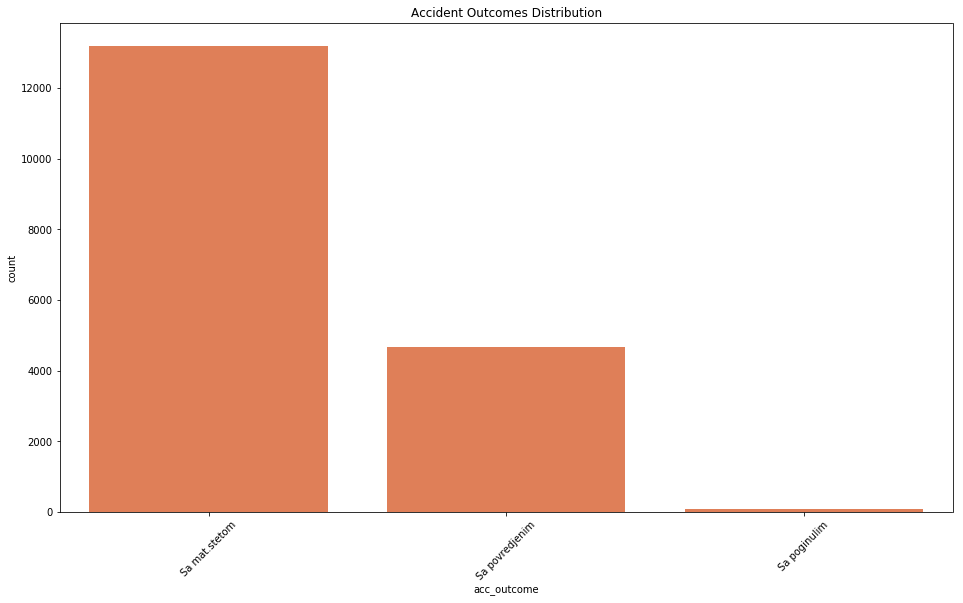

In [160]:
#Plot
order = df['acc_outcome'].value_counts().index

ax = sns.countplot(df['acc_outcome'], order=order, color='#f57542');

ax.set_title('Accident Outcomes Distribution')
plt.xticks(rotation=45);

In [161]:
df['acc_outcome'].value_counts()

Sa mat.stetom     13179
Sa povredjenim     4679
Sa poginulim         98
Name: acc_outcome, dtype: int64

In [162]:
df[df['acc_outcome'] == 'Sa poginulim']

,id,date,long,lat,acc_outcome,acc_type,description
514,1204730.0,2018-01-13 04:30:00,20.400860,44.885470,Sa poginulim,SN SA JEDNIM VOZILOM,Nezgoda sa jednim vozilom – silazak ulevo sa kolovoza na pravcu
491,1204899.0,2018-01-13 17:45:00,20.677460,44.411170,Sa poginulim,SN SA PEŠACIMA,"Prelazak pešaka sleva, van raskrsnice , bez skretanja vozila"
660,1205593.0,2018-01-16 11:10:00,20.476280,44.760950,Sa poginulim,SN SA PEŠACIMA,"Prelazak pešaka zdesna, van raskrsnice, bez skretanja vozila"
729,1205033.0,2018-01-18 02:15:00,20.507840,44.705156,Sa poginulim,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,Najmanje dva vozila koja se kreću istim putem u suprotnim smerovima uz skretanje ulevo ispred drugog vozila
1123,1205925.0,2018-01-26 21:05:00,20.465750,44.799170,Sa poginulim,SN SA PEŠACIMA,"Prelazak pešaka sleva, van raskrsnice , bez skretanja vozila"
1405,1206934.0,2018-01-31 22:40:00,20.624370,44.761520,Sa poginulim,SN SA JEDNIM VOZILOM,"Nezgoda sa jednim vozilom bez prepreka na kolovozu na nepoznat, nespecificiran način"
8897,1221561.0,2018-02-07 15:05:00,20.500200,44.749620,Sa poginulim,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,Najmanje dva vozila koja se kreću istim putem u suprotnim smerovima uz skretanje ulevo ispred drugog vozila
11748,1227994.0,2018-02-09 04:20:00,20.309187,44.747678,Sa poginulim,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila – čeoni sudar
2013,1207917.0,2018-02-14 07:05:00,20.335430,44.732910,Sa poginulim,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila – čeoni sudar
2435,1209126.0,2018-02-23 10:00:00,20.410830,44.615770,Sa poginulim,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,"Najmanje dva vozila koja se kreću istim putem u istom smeru uz skretanje, skretanje ulevo ispred drugog vozila"


## Accident Types

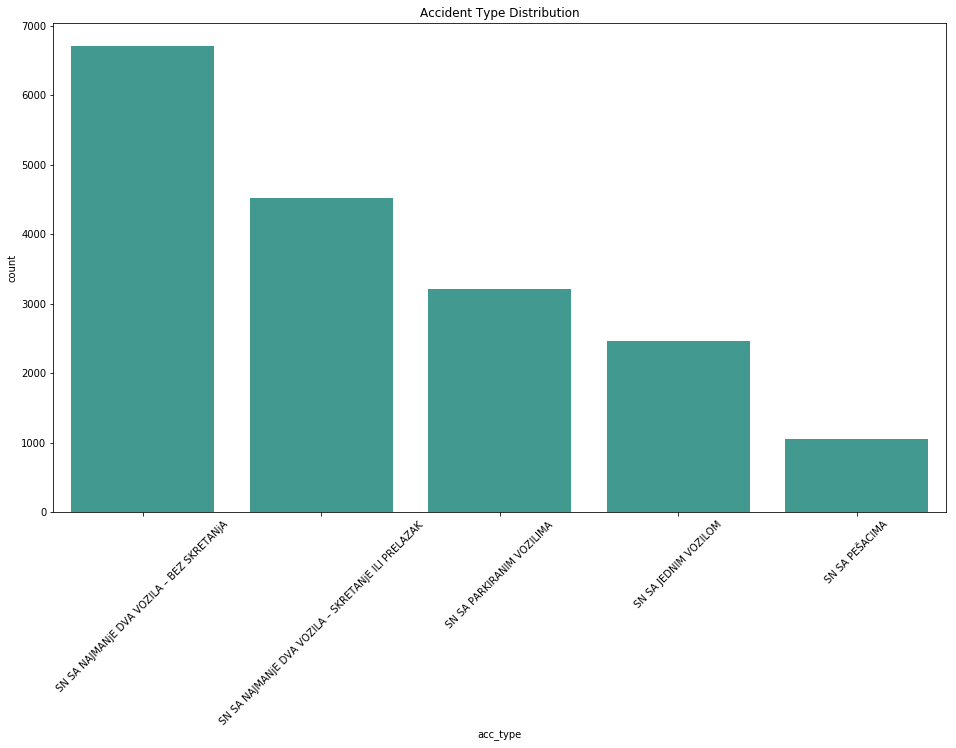

In [163]:
#Plot
order = df['acc_type'].value_counts().index

ax = sns.countplot(df['acc_type'], order=order, color='#32a89b');

ax.set_title('Accident Type Distribution')
plt.xticks(rotation=45);

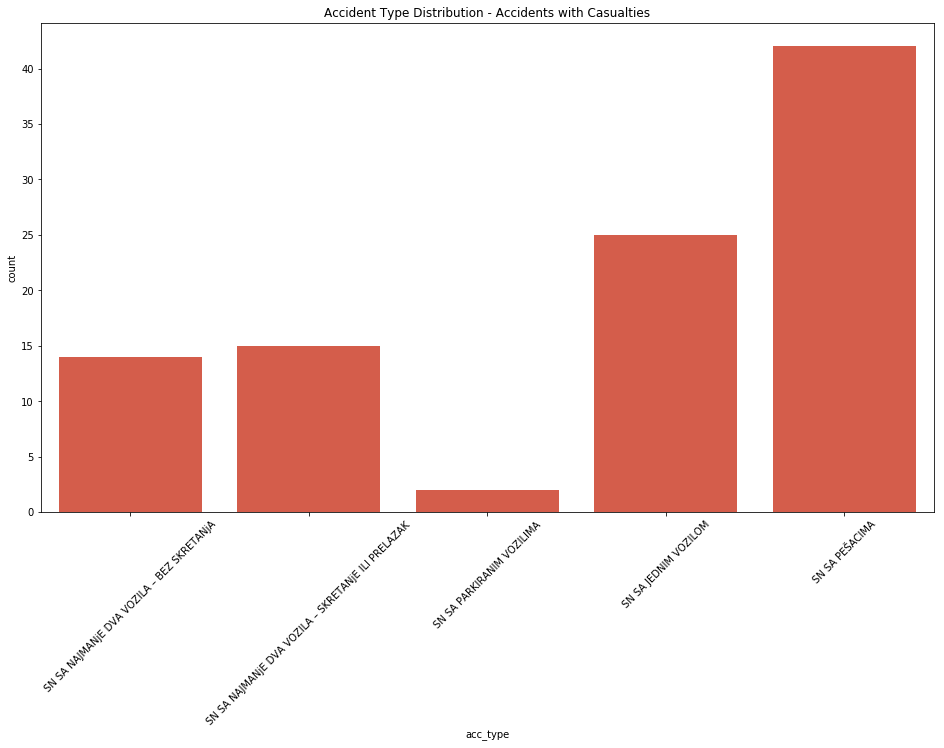

In [164]:
#Plot
topl = df[df['acc_outcome'] == 'Sa poginulim']
order = df['acc_type'].value_counts().index

ax = sns.countplot(topl['acc_type'], order=order, color='#eb4c34');

ax.set_title('Accident Type Distribution - Accidents with Casualties')
plt.xticks(rotation=45);

## Seasonality of Accidents

In [165]:
#Seasonal df
ses_df = df.set_index('date')
ses_df['count'] = 1

#Resample
ses_df = ses_df.resample('1m')[['count']].sum()

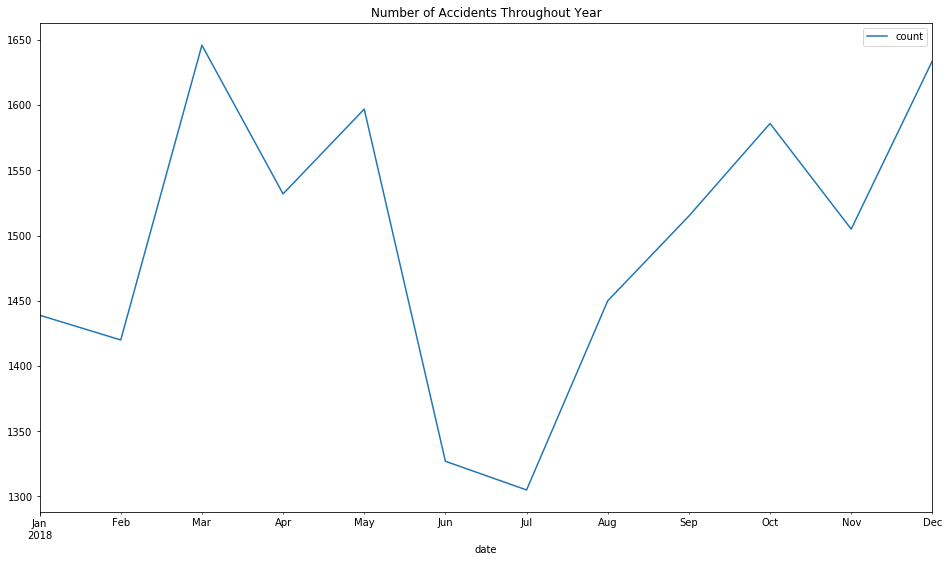

In [175]:
#Plot
ax = ses_df.plot();

ax.set_title('Number of Accidents Throughout The Year');

In [176]:
#Weekday
day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['day_of_week'] = df['date'].dt.dayofweek.map(day_map)

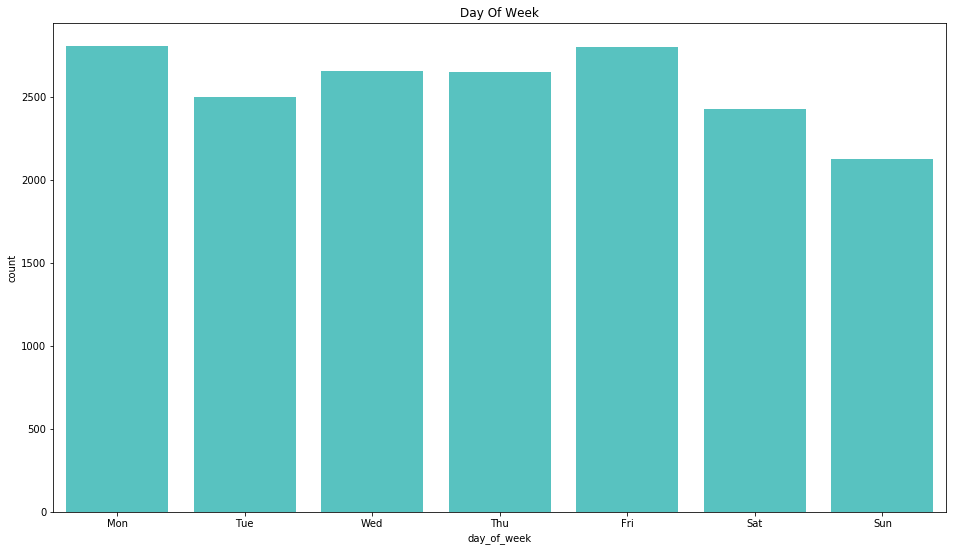

In [177]:
#Plot
ax = sns.countplot(df['day_of_week'], color='#46d4d1');

ax.set_title('Day Of Week');

## GeoLoc 